In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from tqdm import tqdm
import math
from random import sample 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import warnings
import ast
import random
import numpy as np
import pickle
warnings.filterwarnings("ignore")

import ast
ast.literal_eval

import sys
sys.path.append('./models/')
import pernir_metrics
import pretty_plotter
import pernir_user_imitation

### 1. Instacart

In [2]:
train_baskets = pd.read_csv('../data/instacart/train_baskets.csv')
test_samples = pd.read_csv('../data/instacart/test_sample_to_predict_instacart.csv')

In [11]:
#sampling baskest of 100 users with the amount of masked items > 1
ts = test_samples[test_samples.num_to_mask > 1][
    ['basket_id', 'user_id', 'full_basket', 'num_to_mask']].sample(5000)

In [12]:
def generate_masked_baskets(row):
    basket = eval(row['full_basket'])
    num_to_mask = row['num_to_mask']
    
    masked_baskets = []
    for num_items_to_mask in range(1, num_to_mask + 1):
        masked_indices = random.sample(range(len(basket)), num_items_to_mask)
        
        masked_basket = [item for idx, item in enumerate(basket) if idx not in masked_indices]
        masked_baskets.append(masked_basket)
    
    # adding actual_masked_num to indicate how many items were masked
    masked_baskets_with_info = []
    for i, masked_basket in enumerate(masked_baskets):
        masked_baskets_with_info.append({
            'masked_basket': masked_basket,
            'actual_masked_num': i + 1 
        })
    
    return masked_baskets_with_info

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [13]:
model = pernir_user_imitation.Collab(train_baskets, ts, train_url = '../data/instacart/user_sim.pickle')
print('train...')
model.train()

train...


In [14]:
#cool 
assert len(ts.loc[0].masked_basket) == len(eval(ts.loc[0].full_basket)) - ts.loc[0].actual_masked_num

In [15]:
def get_predictions(row):
    return model.predict(row['user_id'], row['masked_basket'])

ts['pred'] = ts.apply(lambda row: get_predictions(row), axis=1)

In [17]:
ts.masked_basket = ts.masked_basket.apply(lambda x: str(x))
ts.full_basket = ts.full_basket.apply(lambda x: str(x))

In [18]:
pernir_metrics.calculate_and_save_precision_recall(ts)

In [19]:
pernir_metrics.calculate_and_save_ndcg(ts)

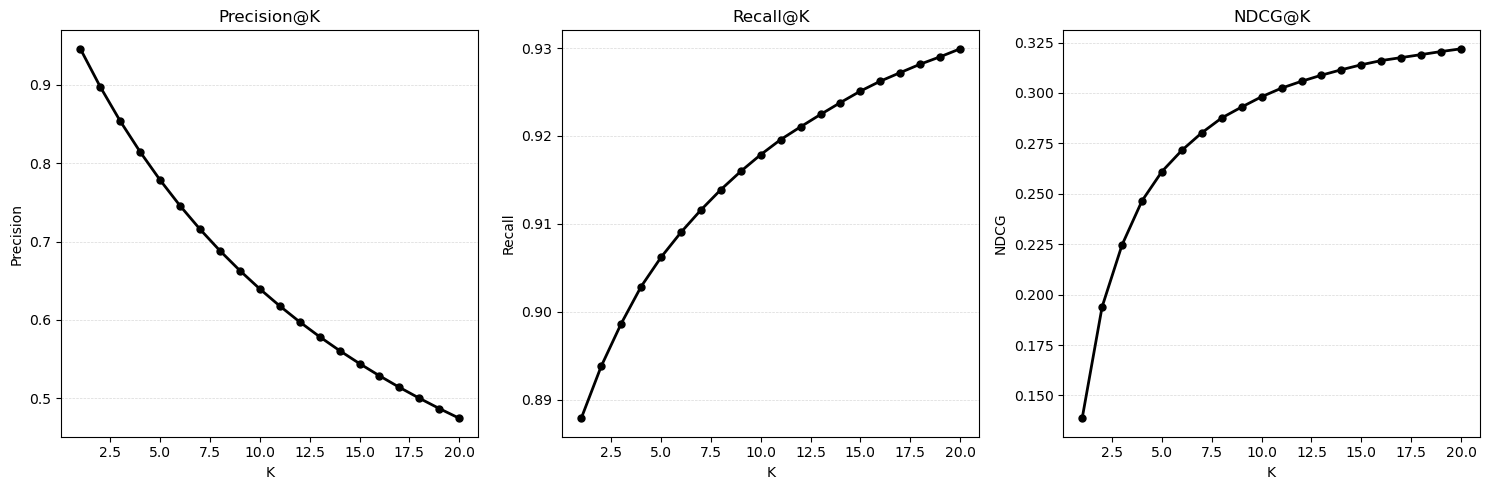

In [20]:
pretty_plotter.plot_pretty_metrics_pernir(ts)

In [23]:
ts.describe().loc[:, ts.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,15233.000000,15233.000000,15233.000000
mean,0.639530,0.917869,0.298121
std,0.098409,0.055562,0.344169
min,0.444444,0.800000,0.000000
25%,0.565217,0.882353,0.000000
50%,0.640000,0.923077,0.289065
75%,0.709677,0.954545,0.500000
max,0.947368,1.000000,1.000000


## 2. Ta Feng

In [24]:
train_baskets = pd.read_csv('../data/ta_feng/train_baskets.csv').drop('index', axis = 1)
test_samples = pd.read_csv('../data/ta_feng/test_sample_to_predict_ta_feng.csv')

In [25]:
ts = test_samples[['basket_id', 'user_id', 'full_basket', 'num_to_mask']].sample(5000)

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [26]:
model = pernir_user_imitation.Collab(train_baskets, ts, train_url = '../data/ta_feng/user_sim.pickle')
print('train...')
model.train()
print('predict...')

train...
predict...


In [27]:
ts['pred'] = ts.apply(lambda row: get_predictions(row), axis=1)

In [29]:
# there are baskets with 0 predictions
ts = ts[ts.pred.apply(lambda x: len(x)) > 0]

In [30]:
ts.masked_basket = ts.masked_basket.apply(lambda x: str(x))
ts.full_basket = ts.full_basket.apply(lambda x: str(x))

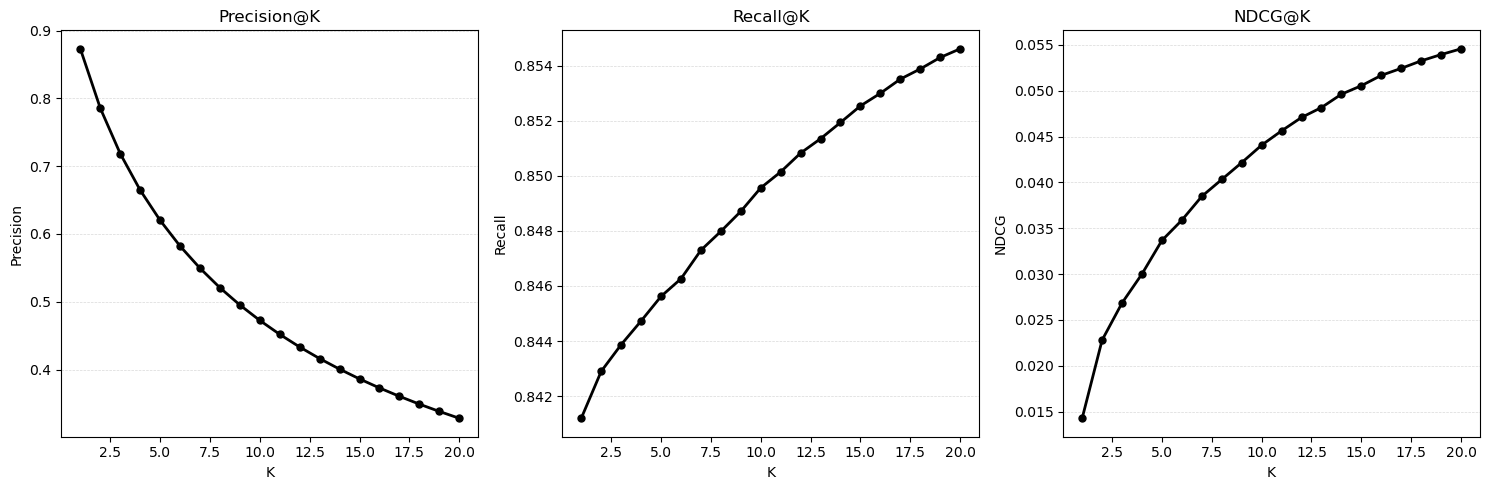

In [31]:
pernir_metrics.calculate_and_save_precision_recall(ts)
pernir_metrics.calculate_and_save_ndcg(ts)
pretty_plotter.plot_pretty_metrics_pernir(ts)

In [32]:
ts.describe().loc[:, ts.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,5181.000000,5181.000000,5181.000000
mean,0.472526,0.849561,0.044067
std,0.179799,0.082634,0.160713
min,0.166667,0.666667,0.000000
25%,0.333333,0.800000,0.000000
50%,0.500000,0.857143,0.000000
75%,0.615385,0.909091,0.000000
max,0.885714,1.000000,1.000000


## 3. Dunnhubpy

In [33]:
train_baskets = pd.read_csv('../data/dunnhumby/train_baskets.csv').drop('index', axis = 1)
test_samples = pd.read_csv('../data/dunnhumby/test_sample_to_predict_dunnhumby.csv')

In [34]:
#using all sampled users
ts = test_samples[['basket_id', 'user_id', 'full_basket', 'num_to_mask']]

ts['masked_basket_info'] = ts.apply(lambda row: generate_masked_baskets(row), axis=1)
ts = ts.explode('masked_basket_info').reset_index(drop=True)

# extracting 'masked_basket' and 'actual_masked_num' from 'masked_basket_info' column
ts['masked_basket'] = ts['masked_basket_info'].apply(lambda x: x['masked_basket'])
ts['actual_masked_num'] = ts['masked_basket_info'].apply(lambda x: x['actual_masked_num'])
ts = ts.drop(columns=['masked_basket_info'])

In [35]:
model = pernir_user_imitation.Collab(train_baskets,ts, train_url = '../data/dunnhumby/user_sim.pickle')
print('train...')
model.train()
print('predict...')

train...
predict...


In [36]:
ts['pred'] = ts.apply(lambda row: get_predictions(row), axis=1)

In [41]:
# there are baskets with 0 predictions
ts = ts[ts.pred.apply(lambda x: len(x)) > 0]

ts.masked_basket = ts.masked_basket.apply(lambda x: str(x))
ts.full_basket = ts.full_basket.apply(lambda x: str(x))

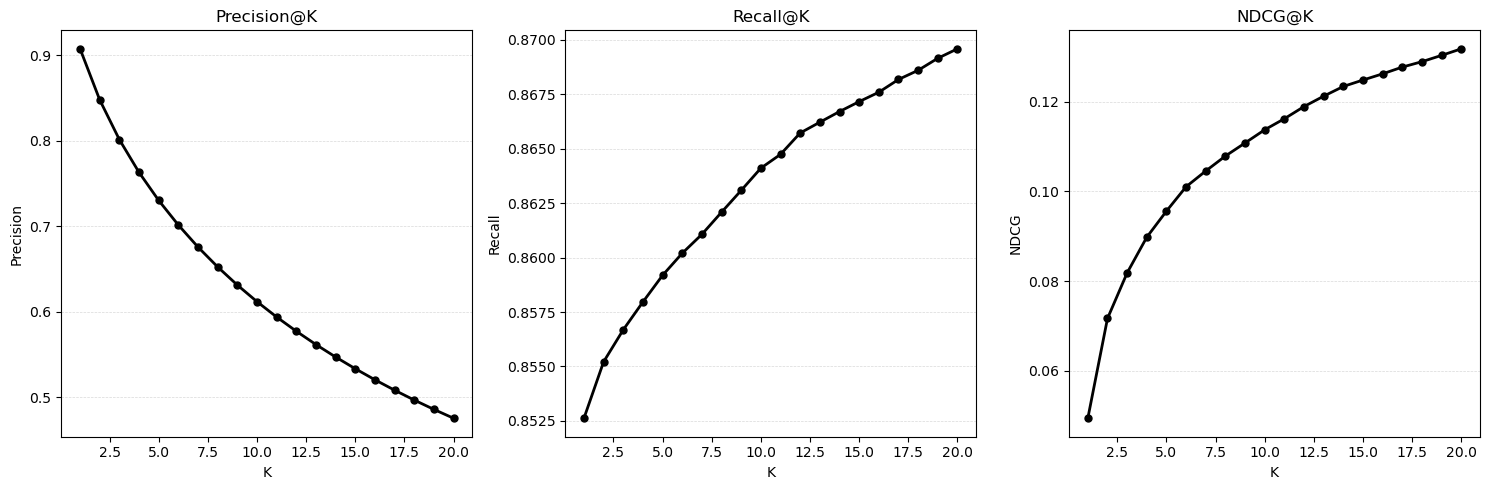

In [42]:
pernir_metrics.calculate_and_save_precision_recall(ts)
pernir_metrics.calculate_and_save_ndcg(ts)
pretty_plotter.plot_pretty_metrics_pernir(ts)

In [44]:
ts.describe().loc[:, ts.describe().columns.str.contains('@10')]

,precision@10,recall@10,ndcg@10
count,6294.000000,6294.000000,6294.000000
mean,0.611889,0.864106,0.113763
std,0.226524,0.106369,0.254964
min,0.090909,0.500000,0.000000
25%,0.473684,0.833333,0.000000
50%,0.678571,0.882353,0.000000
75%,0.795455,0.933333,0.000000
max,0.934579,1.000000,1.000000
